In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp

In [2]:
from main import *

### Elliptical Slice Sampling

- Target : $\pi = \mathcal{N}(\frac{1}{3}, \frac{2}{3})$
- Prior : $\mu_0 = \mathcal{N}(0, 1)$
- likelihood : $\rho(x) \propto \mathcal{N}(x; 1, 2)$


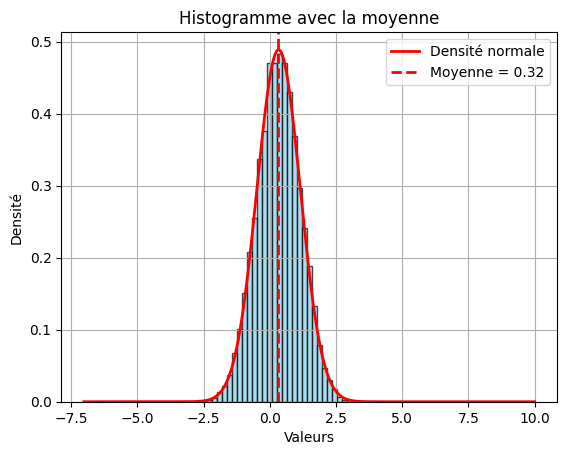

In [47]:
if __name__ == "__main__":
    d = 1  # Dimension
    m = np.ones(d)
    v = 2*np.eye(d)

    x_init = np.array([10])
    N = 10000

    ess_sample = np.array(elliptical_slice_sampling(x_init, m, v, N))
    # Histogramme avec densité (area under histogram = 1)
    plt.hist(ess_sample[1000:], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

    # Ligne de densité normale théorique
    l = np.linspace(min(ess_sample), max(ess_sample), N)
    plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Densité normale')

    mean_value = np.mean(ess_sample) 
    # Afficher
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

# Ajouter titre et légende
    plt.title("Histogramme avec la moyenne")
    plt.xlabel("Valeurs")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(True)
    plt.show()

### Common random number coupling

- One while loop to select always de the same $\theta$

In [126]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2


def coupled_transition(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_p_x, log_p_y = log_likelihood(x, m, v), log_likelihood(y, m, v)
    u = np.log(np.random.uniform(0, 1))
    log_tx = log_p_x + u
    log_ty = log_p_y + u

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x, proposal_y = x * np.cos(theta) + w * np.sin(theta),  y * np.cos(theta) + w * np.sin(theta)
    log_p_proposal_x, log_p_proposal_y = log_likelihood(proposal_x, m, v), log_likelihood(proposal_y, m, v)

    while log_p_proposal_x < log_tx and log_p_proposal_y < log_ty :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal_x, proposal_y = x * np.cos(theta) + w * np.sin(theta),  y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x, log_p_proposal_y = log_likelihood(proposal_x, m, v), log_likelihood(proposal_y, m, v)

    return proposal_x, proposal_y, theta, w


def coupled_ess(x_init, y_init, m, v, N):
    coupled_chain = [(x_init, y_init)]
    x, y = x_init, y_init
    list_theta = []
    list_w = []
    for i in range(N):
        x, y, theta, w = coupled_transition(x, y, m, v)
        list_theta.append(theta)
        list_w.append(w)
        coupled_chain.append((x, y))

    return coupled_chain, list_theta, list_w

In [127]:
if __name__ == "__main__":
    m, v = 1, 2

    x_init, y_init = 5, 10
    N = 10000

    coupled_chain, list_theta, list_w = coupled_ess(x_init, y_init, m, v, N)

In [ ]:
x_sample = np.array([coupled_chain[i][0] for i in range(len(coupled_chain))])
y_sample = np.array([coupled_chain[i][1] for i in range(len(coupled_chain))])
meet_time = []
for i in range(len(coupled_chain)):
    if x_sample[i] == y_sample[i]:
        meet_time.append(i)
n = meet_time[0]


-1.4749815509886468 -1.4749815509886468


np.float64(-1.4749815509886468)

- The coupling seems to be successful meaning that they coincide forever after a finite certain time, but it is false we show easily that if $x_n \neq y_n$ then $x_{n+1} \neq y_{n+1}$ a.s.
proof : suppose $x_n \neq y_n$ and $x_{n+1} = y_{n+1}$ over $A$ s.t $P(A) > 0$ then we have $cos(\theta_{n+1}) = 0$ over A however 
    - $P(cos(\theta_{n+1}) = 0) = 0$

- $\texttt{x}$ sample density compared to the target 

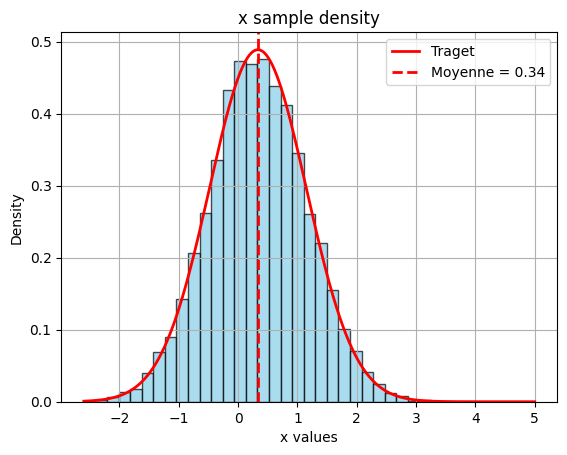

In [121]:
# Histogramme avec densité (area under histogram = 1)
plt.hist(x_sample[1000:], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Ligne de densité normale théorique
l = np.linspace(min(x_sample), max(x_sample), N)
plt.plot(l, norm.pdf(l, 1/3, np.sqrt(2/3)), 'r-', lw=2, label='Traget')

mean_value = np.mean(x_sample) 
    # Afficher
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Moyenne = {mean_value:.2f}')

plt.title('x sample density')
plt.xlabel('x values')
plt.ylabel('Density')
plt.grid()
plt.legend()
plt.show()

- ACF of $\texttt{x}$ sample

<function matplotlib.pyplot.show(close=None, block=None)>

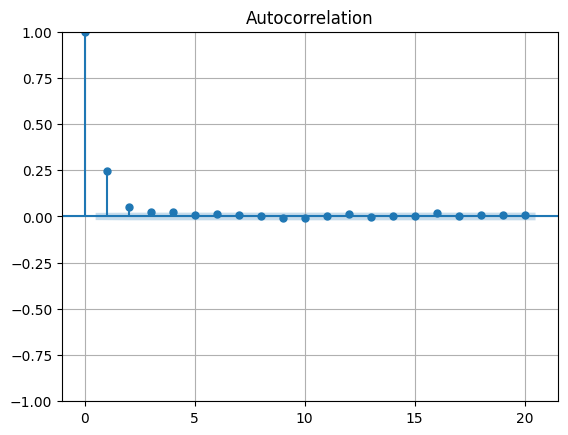

In [45]:
plot_acf(x_sample, lags= 20)
plt.grid()
plt.show

- Now one need to check that the one loop coupling conserves the ESS transition we compare $\texttt{x\_sample}$ and $\texttt{x\_sample}$ with a simple ESS sample 
- We do a Kolmogorov Smirnov test 

In [150]:
if __name__ == "__main__":

    m = np.ones(1)
    v = 2*np.eye(1)
    x_init = np.array([5])
    y_init = np.array([-5])
    N = 10000

    ess_distrib = np.array([transition(y_init, m, v) for _ in range(N)]).reshape(-1)
    coupled_marginal = np.array([coupled_transition(x_init, y_init, m, v)[1] for _ in range(N)]).reshape(-1)
    statistic, p_value = ks_2samp(ess_distrib, coupled_marginal)

    print(f"Statistique KS : {statistic:.4f}")
    print(f"p-value : {p_value:.4f}")

Statistique KS : 0.0154
p-value : 0.1865


- for $\texttt{y}$ sample the test does not reject $H_0$ systematically however for $\texttt{x}$ sample it does.

- See if $\texttt{x}$ and $\texttt{y}$ contracts  

/tmp/ipykernel_4377/2546797401.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(x_sample - y_sample)))


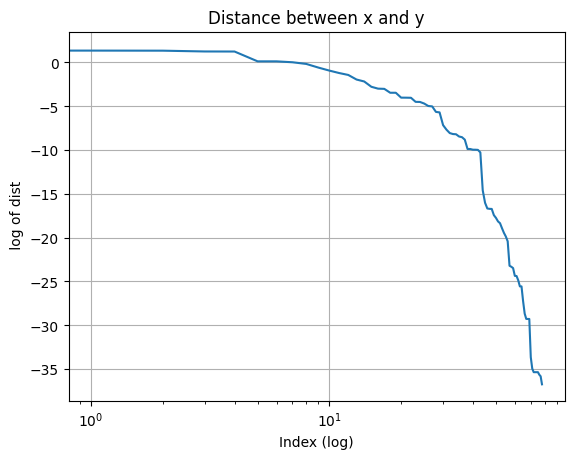

In [152]:
plt.plot(np.log(np.abs(x_sample - y_sample)))
plt.xscale('log')  # Mettre l'axe Y en échelle logarithmique
plt.title("Distance between x and y")
plt.xlabel("Index (log)")
plt.ylabel(" log of dist")
plt.grid()
plt.show()

- Two while loops to have different decisions meaning possibly different $\theta$

In [6]:
def coupled_transition(x, y, m, v):
    w = np.random.normal(0, 1)  # w ~ N(0, I)

    log_px, log_py = log_likelihood(x, m, v), log_likelihood(y, m, v)
    u_slice = np.log(np.random.uniform(0, 1))
    log_tx = log_px + u_slice
    log_ty = log_py + u_slice

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal_x = x * np.cos(theta) + w * np.sin(theta)
    log_proposal_x = log_likelihood(proposal_1, m, v)

    theta_visited = [theta]
    while log_p_proposal_x <= log_tx :
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        theta_visited.append(theta)
        proposal_x = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_x = log_likelihood(proposal_1, m, v)

    proposal_y = y * np.cos(theta_visited[0]) + w * np.sin(theta_visited[0])
    log_proposal_y = log_likelihood(proposal_y, m, v)

    counter = 0
    while log_p_proposal_y <= log_ty :
        if counter < len(theta_visited):
            theta = theta_visited[counter]
        else:
            theta = np.random.uniform(theta_min, theta_max)
        
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        proposal_y = y * np.cos(theta) + w * np.sin(theta)
        log_p_proposal_y = log_likelihood(proposal_y, m, v) 

    return proposal_x, proposal_y


def coupled_ess(x0, y0, m, v, n_iter):
    samples = [(x0, y0)]
    x, y = x0, y0

    for i in range(1, n_iter + 1):
        x, y = coupled_transition(x, y, m, v)
        samples.append((x, y))

    return samples

### Logistic Regression case (density shifting)

### Transition distribution

In [ ]:
def log_likelihood(x, m, v):
    """Unnormalized log Gaussian: -0.5 * (x - m)^T V^{-1} (x - m)"""
    diff = x - m
    
    return (-0.5/v) * diff**2

def transition(x, m, v):
    """
    One step of Elliptical Slice Sampling (ESS)
    
    Parameters:
        x (np.ndarray): Current state
        m (np.ndarray): Mean of Gaussian target
        v (np.ndarray): Covariance of Gaussian target
        
    Returns:
        np.ndarray: New sample from the ESS transition
    """

    w = np.random.normal(0, 1)  # w ~ N(0, I)
    
    log_p_x = log_likelihood(x, m, v)
    log_y = log_p_x + np.log(np.random.uniform(0, 1))  # Slice threshold

    # Initial bracket
    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    # First proposal
    proposal = x * np.cos(theta) + w * np.sin(theta)
    log_p_proposal = log_likelihood(proposal, m, v)

    # Shrinkage loop
    while log_p_proposal <= log_y:
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)
        proposal = x * np.cos(theta) + w * np.sin(theta)
        log_p_proposal = log_likelihood(proposal, m, v)

    return proposal

100%|██████████| 50000/50000 [00:01<00:00, 40777.21it/s]


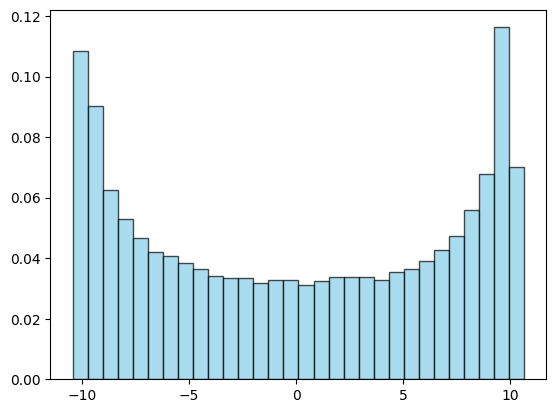

In [ ]:
if __name__ == "__main__":
    m, v = 1, 2
    x = -10
    N = 50000
    
    sample = [transition(x, m, v) for _ in tqdm(range(N))]
    plt.hist(sample, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.show()

In [15]:
print(np.mean(np.array(sample)), np.std(np.array(sample)))

0.044903005904007316 7.073517437771719


- it seems to be an innterpolation between a uniform and a Normal distribution 